<a href="https://colab.research.google.com/github/bitphonix/RL_21CSU437/blob/main/Practical_3_part_4_Thompson_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# include the power socket setup, base classes and helpers
# (see PowerSocketSystem.py)
from PowerSocketSystem import *

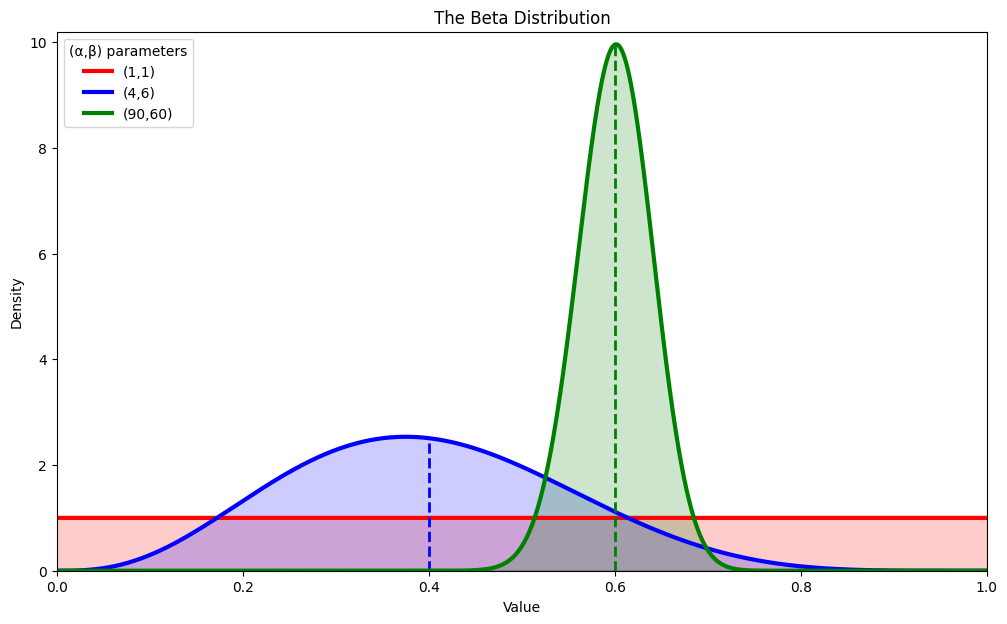

In [2]:
beta = stats.beta

params = [(1, 1),(4,6),(90,60)]
x = np.linspace(0.0, 1.0, 10000)

plt.figure(figsize=(12,7))

colors = ["red","blue","green"]
c_index = 0

for α, β in params:
    y = beta.pdf(x, α, β)
    c = colors[c_index]
    lines = plt.plot(x,y,label = f"({α},{β})",lw = 3, color = c)
    plt.fill_between(x, 0, y, alpha = 0.2, color = c)

    if α > 1:
        mean = α/(α+β)
        plt.vlines(mean, 0, beta.pdf(mean, α, β), colors = c, linestyles = "--", lw = 2)

    plt.autoscale(tight=True)
    c_index += 1

plt.title('The Beta Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

plt.ylim(0,10.2)
plt.legend(loc = 'upper left', title="(α,β) parameters");

In [3]:
class BernoulliThompsonSocket( PowerSocket ):
    def __init__( self, q ):

        self.α = 1  # the number of times this socket returned a charge
        self.β = 1  # the number of times no charge was returned

        # pass the true reward value to the base PowerSocket
        super().__init__(q)

    def charge(self):
        """ return some charge with the socket's predefined probability """
        return np.random.random() < self.q

    def update(self,R):
        """ increase the number of times this socket has been used and
            update the counts of the number of times the socket has and
            has not returned a charge (alpha and beta)"""
        self.n += 1
        self.α += R
        self.β += (1-R)

    def sample(self):
        """ return a value sampled from the beta distribution """
        return np.random.beta(self.α,self.β)

In [4]:
figsize(11.0, 10)
beta = stats.beta
x = np.linspace(0.0,1.0,200)

def plot_sockets(sockets, socket_probabilities ):

    trials = sum([socket.n for socket in sockets])

    colors = ["green","red","blue"]
    c_index = 0

    for i in range(len(socket_probabilities)):

        c = colors[c_index]
        y = beta( sockets[i].α, sockets[i].β )
        p = plt.plot(x, y.pdf(x), lw=2, color=c, label = f'{sockets[i].α-1}/{sockets[i].n}')
        plt.fill_between(x, y.pdf(x), 0, color=c, alpha=0.2 )
        plt.vlines(socket_probabilities[i], 0, y.pdf(socket_probabilities[i]), colors = c, linestyles = "--", lw = 2)
        plt.autoscale(tight = "True")
        plt.title(f"{trials} Trials")
        plt.legend()
        plt.autoscale(tight=True)
        c_index += 1

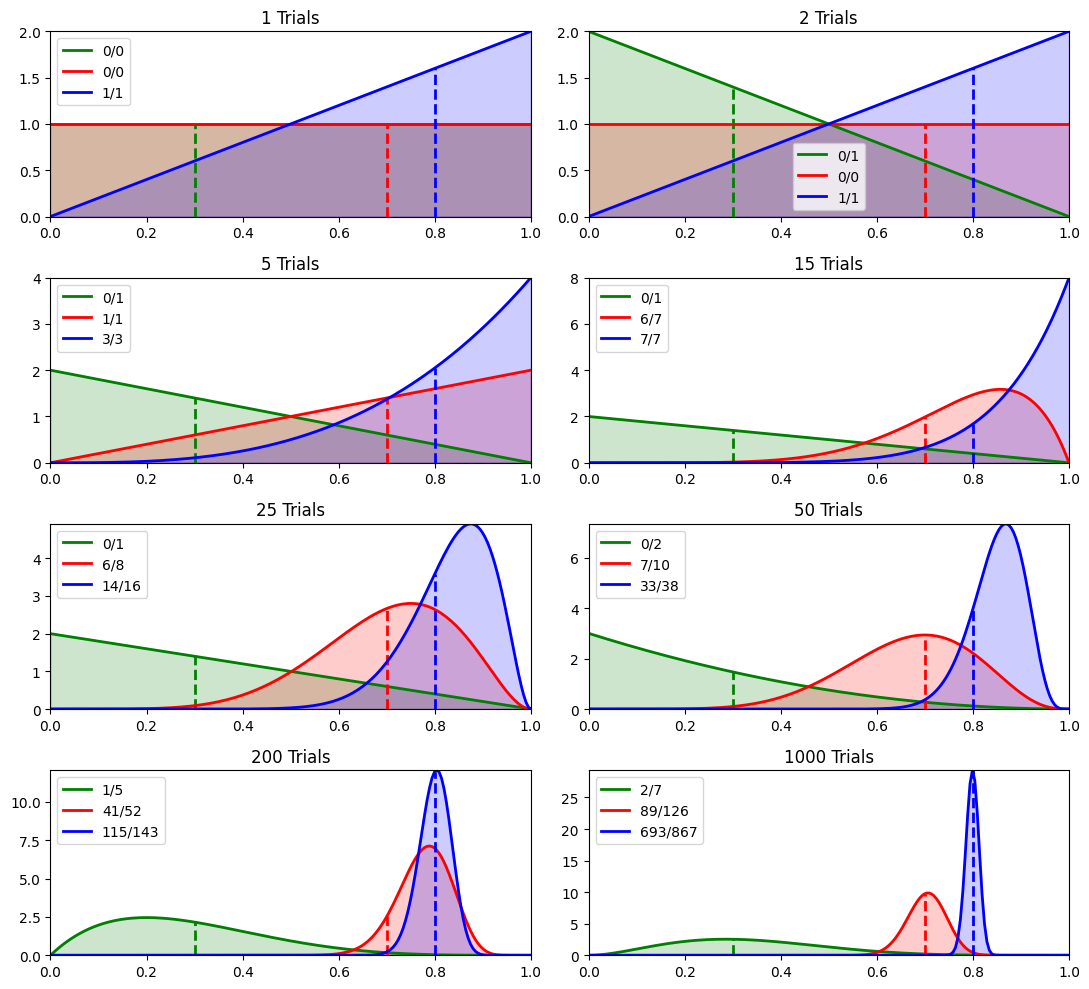

In [5]:
# set the random seed to produce a recreatable graph
seed = 15
random.seed(seed)
np.random.seed(seed)

# the probabilities that each socket returns a charge
socket_probabilities = [0.3,0.7,0.8]

sockets = [BernoulliThompsonSocket(p) for p in socket_probabilities]

draw_samples = [1, 1, 3, 10, 10, 25, 150, 800]
for j,i in enumerate(draw_samples):
    plt.subplot(4, 2, j+1)

    for k in range(i):
        # choose the socket with the current highest sampled value or arbitrary select a socket in the case of a tie
        socket_index = random_argmax([socket.sample() for socket in sockets])

        # charge from the chosen socket and update its mean reward value
        reward = sockets[socket_index].charge()
        sockets[socket_index].update(reward)

    plot_sockets(sockets, socket_probabilities)

    plt.autoscale(tight = True)
plt.tight_layout()

Figure 5.2: Thompson sampling using Beta distributions for 3 probabilistic power sockets, with true probabilities of 0.3, 0.7 and 0.8.

In [6]:
class GaussianThompsonSocket( PowerSocket ):
    def __init__(self, q):

        self.τ_0 = 0.0001  # the posterior precision
        self.μ_0 = 1       # the posterior mean

        # pass the true reward value to the base PowerSocket
        super().__init__(q)

    def sample(self,t):
        """ return a value from the the posterior normal distribution """
        return (np.random.randn() / np.sqrt(self.τ_0)) + self.μ_0

    def update(self,R):
        """ update this socket after it has returned reward value 'R' """

        # do a standard update of the estimated mean
        super().update(R)

        # update the mean and precision of the posterior
        self.μ_0 = ((self.τ_0 * self.μ_0) + (self.n * self.Q))/(self.τ_0 + self.n)
        self.τ_0 += 1

In [7]:
def charge(self):
    """ return a random amount of charge """

    # the reward is a guassian distribution with unit variance
    # around the true value 'q'
    value = np.random.randn() + self.q

In [8]:
def sample(self):
    """ return a value from the the posterior normal distribution """
    return (np.random.randn() / np.sqrt(self.τ_0)) + self.μ_0

In [9]:
figsize(11.0, 10)

norm = stats.norm
x = np.linspace(0.0,16.0,200)

def plot_sockets(sockets, socket_probabilities ):

    trials = sum([socket.n for socket in sockets])
    for socket in sockets:

        y = norm.pdf( x, socket.μ_0, np.sqrt(1./socket.τ_0) )
        p = plt.plot(x, y, lw=2, label = f'{socket.n}/{trials}')
        c = p[0].get_markeredgecolor()
        plt.fill_between(x, y, 0, color=c, alpha=0.2 )
        plt.autoscale(tight = "True")
        plt.title(f"{trials} Trials")
        plt.legend()
        plt.autoscale(tight=True)

True Values = [6, 4, 8, 12, 10]


TypeError: ignored

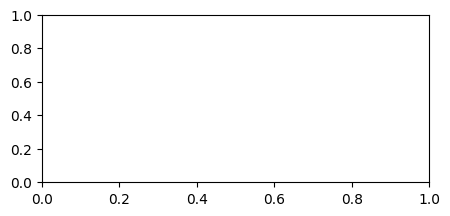

In [10]:
# set the random seed to produce a recreatable graph
seed = 15
random.seed(seed)
np.random.seed(seed)

# create 5 sockets in a fixed order
socket_order = [2,1,3,5,4]

socket_true_values = [((q*2)+2) for q in socket_order]

print(f"True Values = {socket_true_values}")

# create the sockets
# - the mean value of each socket is derived from the socket order index, which is doubled to give
#   distinct values and offset by 2 to keep the distribution above zero
sockets = [GaussianThompsonSocket(q) for q in socket_true_values]

draw_samples = [1, 1, 3, 10, 10, 25, 150, 800]
for j,i in enumerate(draw_samples):
    plt.subplot(4, 2, j+1)

    for k in range(i):

        # choose the socket with the current highest sampled value or arbitrary select a socket in the case of a tie
        socket_samples = [socket.sample() for socket in sockets]
        socket_index = random_argmax(socket_samples)

        # charge from the chosen socket and update its mean reward value
        reward = sockets[socket_index].charge()
        sockets[socket_index].update(reward)

    plot_sockets(sockets, socket_true_values)

    plt.autoscale(tight = True)
plt.tight_layout()

Figure 5.3: Thompson sampling using normal distributions for 5 power sockets, with true reward values of 6, 4, 8, 12 and 10 respectively.

In [ ]:
# run the test 100 times with each test running for 1000 timesteps
number_of_tests = 1000
number_of_steps = 1000

experiment = SocketExperiment(socket_tester   = SocketTester( GaussianThompsonSocket ),
                              number_of_tests = number_of_tests,
                              number_of_steps = number_of_steps)
experiment.run()

In [ ]:
# best socket has a true mean reward of 12
cummulative_optimal_reward = [r*12 for r in range(1,number_of_steps+1)]

# regret is the difference between the optimal reward and the actual reward
regret = cummulative_optimal_reward - experiment.get_cumulative_reward_per_timestep()


fig = plt.figure(figsize=(20,6))
plt.suptitle(f'Thompson Sampling Regret', fontsize=20, fontweight='bold')

plt.subplot(1, 2, 1)
plt.plot(experiment.get_cumulative_reward_per_timestep(),label = "Actual")
plt.plot(cummulative_optimal_reward, label ="Optimal")
plt.plot(regret, label ="Regret")
plt.legend()
plt.title('Cumulative Reward vs Time', fontsize=15)
plt.xlabel('Time Steps')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
plt.title('Regret vs Time', fontsize=15)
plt.plot(regret)
plt.xlabel('Time Steps')
plt.ylabel('Regret')

plt.show()